# Set up environment

In [34]:
library(tidyverse)
options(repr.plot.width=3, repr.plot.height=3)

In [44]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

# Read in dataset

In [2]:
dat_camp <- read_csv("camp_teach.csv")

Parsed with column specification:
cols(
  .default = col_integer(),
  TX = col_character(),
  TG = col_character(),
  GENDER = col_character(),
  ETHNIC = col_character(),
  hemog = col_double(),
  PREFEV = col_double(),
  PREFVC = col_double(),
  POSFEV = col_double(),
  POSFVC = col_double(),
  visitc = col_character()
)
See spec(...) for full column specifications.


# Preprocess

In [53]:
tmp <- dat_camp

# Treatment Group
tmp_map <-        c("bud", "ned", "plbo")
names(tmp_map) <- c("A",   "B",   "C")
tmp$TrtGrp <- tmp_map[tmp$TG]

# Exposed to Smoke
tmp1 <- ifelse(tmp$parent_smokes == 1, 1, 0)
tmp2 <- ifelse(tmp$any_smokes    == 1, 1, 0)
tmp$Expose_Smk <- ifelse((tmp1 + tmp2) > 0, "Exposed", "Not Exposed")

dat_camp_prep <- tmp
head(dat_camp_prep, 3)

TX,TG,id,age_rz,GENDER,ETHNIC,hemog,PREFEV,PREFVC,PREFF,⋯,agehome,anypet,woodstove,dehumid,parent_smokes,any_smokes,visitc,fdays,TrtGrp,Expose_Smk
ned,B,1,5,m,o,12.5,1.38,1.75,79,⋯,50,1,2,2,1,1,000,0,ned,Exposed
ned,B,1,5,m,o,NA,1.31,1.70,77,⋯,NA,NA,NA,NA,NA,NA,002,68,ned,NA
ned,B,1,5,m,o,NA,1.44,1.76,82,⋯,NA,NA,NA,NA,NA,NA,004,175,ned,NA


In [105]:
tmp <- dat_camp_prep

tmp <- tmp %>% filter(visitc == "000")
tmp <- tmp %>% filter(!is.na(PREFEV), !is.na(PREFEVPP))

dat_camp_base <- tmp

In [147]:
print(length(unique(dat_camp_prep$id)))
print(nrow(dat_camp_base))

[1] 695
[1] 686


In [107]:
colnames(dat_camp)

[1] "TX"            "TG"            "id"            "age_rz"       
 [5] "GENDER"        "ETHNIC"        "hemog"         "PREFEV"       
 [9] "PREFVC"        "PREFF"         "PREPF"         "POSFEV"       
[13] "POSFVC"        "POSFF"         "POSPF"         "PREFEVPP"     
[17] "PREFVCPP"      "POSFEVPP"      "POSFVCPP"      "wbc"          
[21] "agehome"       "anypet"        "woodstove"     "dehumid"      
[25] "parent_smokes" "any_smokes"    "visitc"        "fdays"

# Hypothesis

- (1) **Exposure to smoking is associated with decreased lung function at baseline**
    - a. as measured by pre-bronchodilator FEV1PP and 
    - b. as measured by change in FEV1PP after bronchodilator in children with asthma.

**condition:**  under bronchodilator    
**comparison:** smoking vs lung function    
**Time Point:** Baseline  

**hypothesis:**   
- $H_0: $ pre-bronchodilator FEV1PP exposed to smk $>$ pre-bronchodilator FEV1PP not exposed to smk 
- $H_1: $ pre-bronchodilator FEV1PP exposed to smk $\leq$ pre-bronchodilator FEV1PP not exposed to smk 

**hypothesis:**   
- $H_0: $ change in FEV1PP exposed to smk $=$ change in FEV1PP not exposed to smk 
- $H_1: $ change in FEV1PP exposed to smk $\neq$ change in FEV1PP not exposed to smk 

-----

**hypothesis:**   
- $H_0: $ pre-bronchodilator FEV1PP exposed to smk $>$ pre-bronchodilator FEV1PP not exposed to smk 
- $H_1: $ pre-bronchodilator FEV1PP exposed to smk $\leq$ pre-bronchodilator FEV1PP not exposed to smk 

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

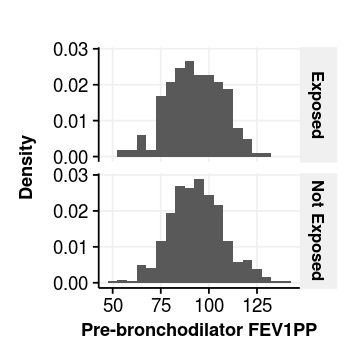

In [131]:
options(repr.plot.width=3, repr.plot.height=3)

gp <- ggplot(dat_camp_base, aes(y=..density.., x = PREFEVPP)) + 
    geom_histogram(binwidth = 5) +
    xlab("Pre-bronchodilator FEV1PP") +
    ylab("Density") +
    #ggtitle("Distribution of \nPre-bronchodilator FEV1PP") +
    facet_grid(Expose_Smk~.) +
    theme_Publication() +
    theme(
        #title = element_text(size=9, face='bold'),
        strip.text.y = element_text(size = 10),
        axis.title.y = element_text(size = 11),
        axis.title.x = element_text(size = 11))
gp

Warning message:
“Ignoring unknown parameters: binwidth”Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

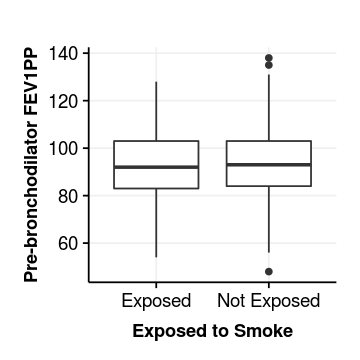

In [132]:
options(repr.plot.width=3, repr.plot.height=3)

gp <- ggplot(dat_camp_base, aes(y = PREFEVPP, x = Expose_Smk)) + 
    geom_boxplot(binwidth = 5) +
    xlab("Exposed to Smoke") +
    ylab("Pre-bronchodilator FEV1PP") +
    theme_Publication() +
    theme(
        axis.title.y = element_text(size = 11),
        axis.title.x = element_text(size = 11))
gp

In [142]:
tmp <- dat_camp_base
tmp <- split(tmp$PREFEVPP, tmp$Expose_Smk)
tmp

$Exposed
  [1]  81  90  81 109 103  84  99 106 102  74 120  85  85  99 109  84 109  96
 [19] 116 106  80  75  84 122 120  97  88  89  90  85 102  82 113  96 111  87
 [37] 104  63  87  81 103  99  94 116  81  86  88  90  97 109 103 122 105 110
 [55]  89  99  62  56 101  89  67 103 104  80  79  74  99  94 101  88  84 109
 [73]  73 110 101 107 115  99  76  92 103  94  58 111  95  92  83 118  88  86
 [91]  82 117  98 109  85 104 109 110 128 101  94 101  94 112 106  85  94 104
[109] 111  99  81  98  82  65 102  74  79  74  83 106  65  79  65  98  76  83
[127]  74  87  73  96  75  83 108  93  83 124  94  88 114  94 117  96  73  87
[145]  92  97  97  88  79  90 105  86  92  84  78 112  93  88  82  89 114 111
[163]  89  94  98  91 101  89  80  95  76  54  70  76 102 102 100  91  77  92
[181] 109  73  82 104  91  81  89  95  86  71 103 105  87  94 106  90  87  81
[199]  67 106  77 112  81

$`Not Exposed`
  [1] 104 112 109  98 100  97 107 103  95  76 102 108 107  91  89  95  83  79
 [19]  83  77 100 115 109  91 113  81 106 100  76 109  87  69 114 124  88  98
 [37] 112  96 116  95 100  76 103  91 106  84  97  97 123  70 108  85 109 102
 [55]  82  90  81  78 122  91 102 118  94 119 138 103 103 104  64  73  90  83
 [73] 118  81  74 104  48  76  91 104  87  95 106 100  92  82 124  89 102  84
 [91] 105  86 109  93  89  88  98  97  81  94  97  86  93  91  89  90 103 118
[109] 109  84  92  86  77  93  98  96  91  95 103  94  98  82  89  90  74 106
[127]  92 119  95  70 130 119 116  82  81  99 106 106 104  91  91  93  95 106
[145]  94  83  95 112  67 109  83  81 105  84 107 109 120 115  75 101  96  96
[163]  73  97 107 102 101  69  99  95 102  87  81 101  66  94  92 104  87 126
[181] 113 102  75  98  80  87 105  78  98  96 105 101  84  81  85  85  90  90
[199] 104  97  87  88 131 125  92  93  65 106 106 102 102  92  82  82  86  86
[217] 122  67 129  71  95  81  81  83 101 108 109  73  90  92 122  94  96  88
[235]  85 109  93  84  59  85  98  94 118  84  69  98 100  87  96  76 135 108
[253] 124  93  91  97  92  81  97  92  82  75  89  74  90 105 100  85 106  78
[271] 110  78  80  78  86  95  87 104  83  88  79 101 114  86  65  92 106  96
[289] 106  94  99  91  88 108  91  80  83 109  95  84  73  93  92  81  82  93
[307] 105  84  82 101  78  96  98  87  96 102  86 111  95  77  95  95  75  91
[325]  82  94  93  80  84  72  72 103  87 100  75  94  90 120  83  81 101 106
[343]  56  64 127 117  76  70  76  89  92  87  91 101  89 105  64 107  78  98
[361] 106  56  89 113  81 102 100  83  93  64  74  86  78 105  94  81  64 104
[379]  85  91  79  90 100  88  84  86  88  86 100  87  80 106  97  65  95  97
[397] 101  76  92  94  94  95  87 100 128  93 100 124  98  95 107  89 112 118
[415]  92  92 106  87  98  83 114 101  83  90  82 107 108  82  99  89 100 107
[433] 103  97  76  92  92  84  71 119  78  77 111  84  78  86  98 106 113  84
[451]  76  83 101  98 100  97  97 110  81 113  85  67  95 104 116  93 106  91
[469]  84  88 108 108  95  73 120  81 124  86  86  87 109  99 102

In [146]:
#t.test(tmp$Exposed, tmp$`Not Exposed`, alternative="two.sided", var.equal=FALSE, conf.level=0.95)
t.test(tmp$Exposed, tmp$`Not Exposed`, alternative="less", var.equal=FALSE, conf.level=0.95)


	Welch Two Sample t-test

data:  tmp$Exposed and tmp$`Not Exposed`
t = -0.87828, df = 373.97, p-value = 0.1902
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf 0.9169963
sample estimates:
mean of x mean of y 
 92.70443  93.74948 


-----

**hypothesis:**   
- $H_0: $ change in FEV1PP exposed to smk $=$ change in FEV1PP not exposed to smk 
- $H_1: $ change in FEV1PP exposed to smk $\neq$ change in FEV1PP not exposed to smk 

In [76]:
colnames(dat_camp_base)

[1] "TX"            "TG"            "id"            "age_rz"       
 [5] "GENDER"        "ETHNIC"        "hemog"         "PREFEV"       
 [9] "PREFVC"        "PREFF"         "PREPF"         "POSFEV"       
[13] "POSFVC"        "POSFF"         "POSPF"         "PREFEVPP"     
[17] "PREFVCPP"      "POSFEVPP"      "POSFVCPP"      "wbc"          
[21] "agehome"       "anypet"        "woodstove"     "dehumid"      
[25] "parent_smokes" "any_smokes"    "visitc"        "fdays"        
[29] "TrtGrp"        "Expose_Smk"

In [110]:
dat_camp_base %>% select(PREFEV, POSFEVPP, PREFEVPP) %>% filter(is.na(PREFEVPP))

PREFEV,POSFEVPP,PREFEVPP


In [153]:
tmp <- dat_camp_base
tmp <- tmp %>% 
    mutate(DIFF_FEVPP = POSFEVPP - PREFEVPP)
tmp %>% head(2)

TX,TG,id,age_rz,GENDER,ETHNIC,hemog,PREFEV,PREFVC,PREFF,⋯,anypet,woodstove,dehumid,parent_smokes,any_smokes,visitc,fdays,TrtGrp,Expose_Smk,DIFF_FEVPP
ned,B,1,5,m,o,12.5,1.38,1.75,79,⋯,1,2,2,1,1,000,0,ned,Exposed,10
ned,B,2,11,m,b,12.5,1.78,2.49,71,⋯,1,2,1,2,1,000,0,ned,Exposed,17


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

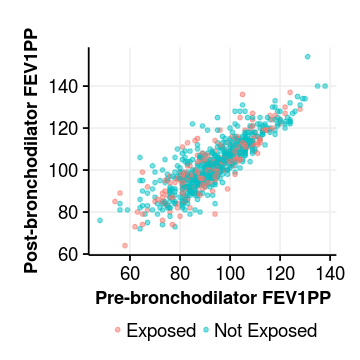

In [150]:
options(repr.plot.width=3, repr.plot.height=3)

tmp <- dat_camp_base
tmp <- tmp %>% 
    mutate(DIFF_FEVPP = POSFEVPP - PREFEVPP)

gp <- ggplot(tmp, aes(x = PREFEVPP, y = POSFEVPP, color = Expose_Smk)) + 
    geom_point(size = 1, alpha = 0.5) +
    xlab("Pre-bronchodilator FEV1PP") +
    ylab("Post-bronchodilator FEV1PP") +
    theme_Publication() +
    theme(
        legend.title = element_blank(),
        axis.title.y = element_text(size = 11),
        axis.title.x = element_text(size = 11))
gp

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

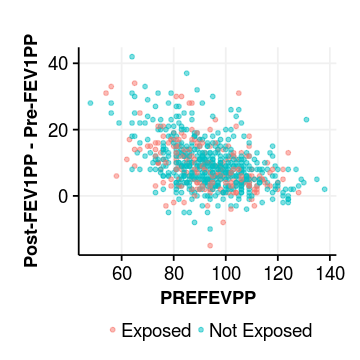

In [151]:
options(repr.plot.width=3, repr.plot.height=3)

tmp <- dat_camp_base
tmp <- tmp %>% 
    mutate(DIFF_FEVPP = POSFEVPP - PREFEVPP)

gp <- ggplot(tmp, aes(x = PREFEVPP, y = DIFF_FEVPP, color = Expose_Smk)) + 
    geom_point(size = 1, alpha = 0.5) +
    ylab("Post-FEV1PP - Pre-FEV1PP") +
    xlab("PREFEVPP") +
    theme_Publication() +
    theme(
        legend.title = element_blank(),
        axis.title.y = element_text(size = 11),
        axis.title.x = element_text(size = 11))
gp

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”

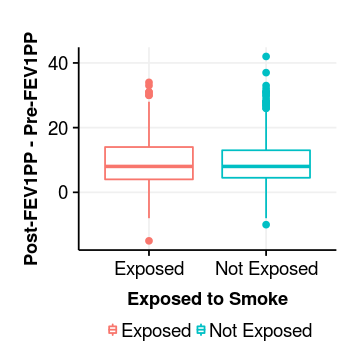

In [152]:
options(repr.plot.width=3, repr.plot.height=3)

tmp <- dat_camp_base
tmp <- tmp %>% 
    mutate(DIFF_FEVPP = POSFEVPP - PREFEVPP)

gp <- ggplot(tmp, aes(x = Expose_Smk, y = DIFF_FEVPP, color = Expose_Smk)) + 
    geom_boxplot() +
    ylab("Post-FEV1PP - Pre-FEV1PP") +
    xlab("Exposed to Smoke") +
    theme_Publication() +
    theme(
        legend.title = element_blank(),
        axis.title.y = element_text(size = 11),
        axis.title.x = element_text(size = 11))
gp

In [137]:
tmp <- dat_camp_base
tmp <- tmp %>% 
    mutate(DIFF_FEVPP = POSFEVPP - PREFEVPP) %>%
    mutate(AVE_FEVPP  = (POSFEVPP + PREFEVPP) / 2)

tmp <- split(tmp$DIFF_FEVPP, tmp$Expose_Smk)
tmp

$Exposed
  [1]  10  17  30  15   5  13  14  13  12  10   4   7   4   6   5   7   6   6
 [19]   3   3  19   8  -2   8   2  14   5   2   4  10  -4   5   6   9   2  20
 [37]  21  17   5  11   1   8   5  10  12   9   7   9   9   3  13   5   8   8
 [55]   4  10  11  33  11  15  14   3  11  15  17  16   1  15   7  17  18  18
 [73]  16  -1  15   4   4  -8   4  10  12   4   6  -3   2  13   3   8  11   6
 [91]  15   3   6   4  11   1   3   6   1   6  10   1  20   1   4  12   1   4
[109]   5   6  15   5   9   9   4  10   5  10  30   4  14  17  34   8  11  19
[127]  21   2   3  23  13   8  12  10  12  13   2   0   5 -15   7  16  12  28
[145]   2   7   7  10   3   2  31  28   8  14  16   3  -3   8   3   4   5   1
[163]  16   7   2   9   7  19  -2   4  21  31  15  18   7   3   4  16  -3   8
[181]  12  14  17   1   3   8   7   6  14  15   8   8  12   3   5  15  17  13
[199]  25   6  10   2  17

$`Not Exposed`
  [1]   6  13  12  10   9   6  18  18   9  16  13   6   4  11  32   9   9  23
 [19]   3   9   3   5   4  12   5  15  12  15   9  -1  15  22   7  -2  -8  12
 [37]   3   5   8   8  20   6   9   2   7  13  13   3   2  24   5  20   3   7
 [55]   5  11   6  18  -2   5  -3   1  11   6   2   9   6   6  31   8  13  21
 [73]  -1   4  20  24  28  14   9  -3   2  18   1  11   4   3  -1   0   0  20
 [91]   0  11   3  10  19   5  10   3   3   0   4   2   4   6   6   8   2  12
[109]   8  12   7  12  11  15   9   0  17  12  12   2   9  24  12  11  31  10
[127]   4   9  11  17   4   3   4  16  14   7  11   8   3  10   7  -5   5  22
[145]   6  16  30   8  22  16  14   4  26  -5   9   1   3  10  20   3   6  15
[163]   1   1   7  20   5  33   8   3   7  10  12   3  13   5  11   3  25   2
[181]   8   7  21   9  17  16  -1  10   7   6   7   9   6  15   4   4  17   2
[199]  10  16   1  18  23   2   5  12  30   4   7   2   6   8  10  22  14   4
[217]   1   8   5   8  10  18   8   9  12   6   0  12  11  13   0  13   9   1
[235]  37   2  16   6  22  14   9   8  15  12  12  15   9   7   9   6   5  -4
[253]   0   5  13  14  11   1  19  11  27   7   8  10   5   9   8   9   2  -5
[271]   8   6   7   6  12  11  10   9  13   6  18   2  -2  13  25   6   3   3
[289]   8   7  -1  12  19  10  12  19   5   9   6  12  11   0  10  24  12  15
[307]  11  25  10   6  21   3  10   6  13  14   9   5   4  14   2  24  23   9
[325]  13   9  10  21   6  10  23  11   8  14   8  13   6   8   6  10   7   3
[343]  28  42   8  13  14  29  11   5   4  23  28  10   9   6  18   8   7  11
[361]   2  25   9   5  27  26   2  15   5  22  11  -5  28   5  -1   8   8   4
[379]   9   3  31   9   1  14   9   9  18   5   5  -1  16   1   3  18  16   8
[397]   7  15   0   3 -10   9   6   7   3   3   5   8   5   7   5  10  10   6
[415]  18   9   4  13  17   1   8   8   9  15   4   5  13  -1   1  14   7  11
[433]   8   8  13   5   7   8  13   2  12  20  11  10  13   3   8   9   4   4
[451]   2  20  17   6  12  -3   4   0  13   4  15  16   7   4   2   9   4  -3
[469]   7  18   6   5  10  27   4   2  -1  10   6   7   5   1  10

In [141]:
t.test(tmp$Exposed, tmp$`Not Exposed`, alternative="two.sided", var.equal=FALSE, conf.level=0.95)


	Welch Two Sample t-test

data:  tmp$Exposed and tmp$`Not Exposed`
t = -0.43557, df = 378.78, p-value = 0.6634
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.4979189  0.9546191
sample estimates:
mean of x mean of y 
 9.192118  9.463768 
